In [2]:
import numpy as np
from stateinterpreter.utils.numerical_utils import gaussian_kde
import scipy.optimize as opt
import networkx as nx
from copy import deepcopy
from stateinterpreter import load_dataframe
#Paranoia
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
plt.set_cmap('fessa')

<Figure size 432x288 with 0 Axes>

In [3]:
kBT = 2.5
data_path = '../../../data/md_datasets/BPTI-unbiased/'
colvar_file = data_path + 'COLVAR.csv'
start,stop,stride=0,None,1
colvar = load_dataframe(colvar_file, start, stop, stride)

In [7]:
def find_fes_fixed_points(centers, bandwidth, init_points, tol=1e-5, return_kde = False):
    #Ok only for 1d data. Not checking for saddle points, not checking for dimentions
    kde = gaussian_kde(centers, bandwidth=bandwidth)
    dKDE = lambda x: -kde.grad(x, logpdf=True)
    roots, converged, _ = opt.newton(dKDE,init_points, tol=tol*1e-2, full_output=True, disp=False)
    b = roots[converged]
    b.sort()
    d = np.append(True, np.diff(b))
    roots = b[d>tol]
    if not return_kde:
        return roots[:, np.newaxis]
    else:
        return roots[:, np.newaxis], kde

def get_state_bounds(fixed_points, kde, bounds):
    num_fixed_points = fixed_points.shape[0]
    if num_fixed_points == 1:
        maxima = np.array([[]])
    else:
        diff_signs = np.ones(num_fixed_points -1 )
        diff_signs[1::2] *= -1
        diffs = np.diff(-kde.logpdf(fixed_points), axis=0)
        assert(np.allclose(diff_signs, np.sign(diffs)))
        maxima = fixed_points[1::2]
    state_bounds = []
    maxima = np.insert(maxima, 0, [bounds[0]])
    maxima = np.append(maxima, [bounds[1]])
    for i in range(len(maxima) -1):
        inf = maxima[i]
        sup = maxima[i + 1]
        data = dict()
        data['bounds'] = [inf, sup]
        data['enclosed_minima'] = fixed_points[i*2]
        data['f_min'] = -kde.logpdf(data['enclosed_minima'])
        if i == 0:
            data['f_infbdry'] = None
        else: 
            data['f_infbdry'] = -kde.logpdf(np.array(inf))
        if i == len(maxima) - 2: 
            data['f_supbdry'] = None 
        else:
            data['f_supbdry'] = - kde.logpdf(np.array(sup))
        state_bounds.append(data)
    return state_bounds

def fuse_bounds(state_bounds, tol = 0.5):
    state_bounds = deepcopy(state_bounds)
    for idx, d in enumerate(state_bounds):
        if d['f_infbdry'] == None:
            if d['f_supbdry'] == None:
                #Already single state
                pass
            else:
                d_sup = d['f_supbdry'] - d['f_min']
                if d_sup < tol:
                    return fuse_bounds(fuse_above(state_bounds, idx), tol)
        elif d['f_supbdry'] == None:
            if d['f_infbdry'] == None:
                #Already single state
                pass
            else:
                d_inf = d['f_infbdry'] - d['f_min']
                if d_inf < tol:
                    return fuse_bounds(fuse_below(state_bounds, idx), tol)
        else:
            d_sup = d['f_supbdry'] - d['f_min']
            d_inf = d['f_infbdry'] - d['f_min']
            if (d_sup < tol) and (d_inf >= tol):
                return fuse_bounds(fuse_above(state_bounds, idx), tol)
            if (d_sup >= tol) and (d_inf < tol):
                return fuse_bounds(fuse_below(state_bounds, idx), tol)
            if (d_sup < tol) and (d_inf < tol):
                if d_inf < d_sup:
                    return fuse_bounds(fuse_below(state_bounds, idx), tol)
                else:
                    return fuse_bounds(fuse_above(state_bounds, idx), tol)
            else:
                pass
    return state_bounds
    
def fuse_below(state_bounds, idx):
    assert idx > 0
    state_bounds[idx - 1]['bounds'][1] = state_bounds[idx]['bounds'][1]
    state_bounds[idx -1]['f_supbdry'] = state_bounds[idx]['f_supbdry']
    if state_bounds[idx -1]['f_min'] >= state_bounds[idx]['f_min']:
        state_bounds[idx -1]['f_min'] = state_bounds[idx]['f_min']
        state_bounds[idx -1]['enclosed_minima'] = state_bounds[idx]['enclosed_minima']
    state_bounds.pop(idx)
    return state_bounds

def fuse_above(state_bounds, idx):
    assert idx < len(state_bounds) - 1
    state_bounds[idx + 1]['bounds'][0] = state_bounds[idx]['bounds'][0]
    state_bounds[idx + 1]['f_infbdry'] = state_bounds[idx]['f_infbdry']
    if state_bounds[idx + 1]['f_min'] >= state_bounds[idx]['f_min']:
        state_bounds[idx + 1]['f_min'] = state_bounds[idx]['f_min']
        state_bounds[idx + 1]['enclosed_minima'] = state_bounds[idx]['enclosed_minima']
    state_bounds.pop(idx)
    return state_bounds

def branch_tica(centers, bandwidth, fusing_tolerance=1):
    inf, sup = np.min(centers), np.max(centers)
    padding = 1.1
    init_points = np.arange(inf*padding, sup*padding, bandwidth)[:, np.newaxis]
    fixed_points, kde = find_fes_fixed_points(centers[:, np.newaxis], bandwidth, init_points, return_kde = True)
    state_bounds = get_state_bounds(fixed_points, kde, [inf, sup])
    state_bounds = fuse_bounds(state_bounds, tol = fusing_tolerance)
    for d in state_bounds:
        inf = d['bounds'][0]
        sup = d['bounds'][1]
        d['mask'] = np.logical_and(centers > inf, centers < sup)
    return state_bounds

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, leaf_vs_root_factor = 0.5):

    '''
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    Based on Joel's answer at https://stackoverflow.com/a/29597209/2966723,
    but with some modifications.  

    We include this because it may be useful for plotting transmission trees,
    and there is currently no networkx equivalent (though it may be coming soon).
    
    There are two basic approaches we think of to allocate the horizontal 
    location of a node.  
    
    - Top down: we allocate horizontal space to a node.  Then its ``k`` 
      descendants split up that horizontal space equally.  This tends to result
      in overlapping nodes when some have many descendants.
    - Bottom up: we allocate horizontal space to each leaf node.  A node at a 
      higher level gets the entire space allocated to its descendant leaves.
      Based on this, leaf nodes at higher levels get the same space as leaf
      nodes very deep in the tree.  
      
    We use use both of these approaches simultaneously with ``leaf_vs_root_factor`` 
    determining how much of the horizontal space is based on the bottom up 
    or top down approaches.  ``0`` gives pure bottom up, while 1 gives pure top
    down.   
    
    
    :Arguments: 
    
    **G** the graph (must be a tree)

    **root** the root node of the tree 
    - if the tree is directed and this is not given, the root will be found and used
    - if the tree is directed and this is given, then the positions will be 
      just for the descendants of this node.
    - if the tree is undirected and not given, then a random choice will be used.

    **width** horizontal space allocated for this branch - avoids overlap with other branches

    **vert_gap** gap between levels of hierarchy

    **vert_loc** vertical location of root
    
    **leaf_vs_root_factor**

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = np.random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, leftmost, width, leafdx = 0.2, vert_gap = 0.2, vert_loc = 0, 
                    xcenter = 0.5, rootpos = None, 
                    leafpos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if rootpos is None:
            rootpos = {root:(xcenter,vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}
        children = list(G.neighbors(root))
        leaf_count = 0
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            rootdx = width/len(children)
            nextx = xcenter - width/2 - rootdx/2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(G,child, leftmost+leaf_count*leafdx, 
                                    width=rootdx, leafdx=leafdx,
                                    vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, 
                                    xcenter=nextx, rootpos=rootpos, leafpos=leafpos, parent = root)
                leaf_count += newleaves

            leftmostchild = min((x for x,y in [leafpos[child] for child in children]))
            rightmostchild = max((x for x,y in [leafpos[child] for child in children]))
            leafpos[root] = ((leftmostchild+rightmostchild)/2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root]  = (leftmost, vert_loc)
        return rootpos, leafpos, leaf_count

    xcenter = width/2.
    if isinstance(G, nx.DiGraph):
        leafcount = len([node for node in nx.descendants(G, root) if G.out_degree(node)==0])
    elif isinstance(G, nx.Graph):
        leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==1 and node != root])
    rootpos, leafpos, leaf_count = _hierarchy_pos(G, root, 0, width, 
                                                    leafdx=width*1./leafcount, 
                                                    vert_gap=vert_gap, 
                                                    vert_loc = vert_loc, 
                                                    xcenter = xcenter)
    pos = {}
    for node in rootpos:
        pos[node] = (leaf_vs_root_factor*leafpos[node][0] + (1-leaf_vs_root_factor)*rootpos[node][0], leafpos[node][1]) 
    xmax = max(x for x,y in pos.values())
    for node in pos:
        pos[node]= (pos[node][0]*width/xmax, pos[node][1])
    return pos
    
def populate_tree(T, parent_node, ticas, bandwidth, fusing_tolerance):
    parent_mask = T.nodes[parent_node]['mask']
    if ticas.shape[1] >= 1:
        tica = ticas[parent_mask,0]
        next_tica = ticas[:, 1:]
    elif ticas.shape[1] == 0:
        return
    leafs = branch_tica(tica, bandwidth, fusing_tolerance=fusing_tolerance)
    for leaf_id, leaf in enumerate(leafs):
        leaf_mask = np.zeros_like(parent_mask)
        nonzero_idxs = parent_mask.nonzero()[0]
        leaf_mask[nonzero_idxs] = leaf['mask']
        leaf_name = parent_node + f".{leaf_id + 1}"
        T.add_node(leaf_name, mask = leaf_mask)
        T.add_edge(parent_node, leaf_name)
        populate_tree(T, leaf_name, next_tica, bandwidth, fusing_tolerance)

def state_tree(ticas, bandwidth, fusing_tolerance=1):
    T = nx.DiGraph()
    T.add_node('0', mask=np.ones(ticas.shape[0], dtype=bool))
    populate_tree(T, '0', ticas, bandwidth, fusing_tolerance)
    relabel_map = dict()
    for node in T.nodes:
        if node == '0':
            relabel_map[node] = 'Boltzmann'
        else:
            relabel_map[node] = node[2:]
    T = nx.relabel_nodes(T,relabel_map, copy=False)
    unchanged = False
    while not unchanged:
        unchanged = True
        trimming_list = []
        for node in T.nodes:
            if T.out_degree(node) == 0:
                parent_node = list(T.in_edges(node))[0][0]
                if T.out_degree(parent_node) == 1:
                    unchanged = False
                    trimming_list.append(node)
        T.remove_nodes_from(trimming_list)
    return T

In [8]:
bandwidth = 0.05
ticas = colvar.values
T = state_tree(ticas, bandwidth)

/home/novelli/anaconda3/lib/python3.8/site-packages/scipy/optimize/zeros.py:459: RuntimeWarning: some failed to converge after 50 iterations
  warnings.warn(msg, RuntimeWarning)


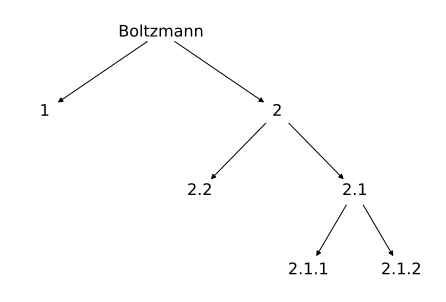

In [6]:
pos = hierarchy_pos(T)
options = {
    "with_labels": True,
    "font_size": 16,
    "node_size": 1000,
    "node_color": "white",
    "edgecolors": "white",
    "linewidths": 1,
    "width": 1,
}
nx.draw(T, pos, **options)